In [208]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt

In [209]:
raw_train_df = pd.read_csv("./data/train.csv")
raw_test_df = pd.read_csv("./data/test.csv")

In [210]:
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [211]:
del raw_train_df['keyword']
del raw_train_df['location']

In [212]:
# Replaces the null values in the data with an empty string
train_data = raw_train_df.where((pd.notnull(raw_train_df)),'')
test_data = raw_test_df.where((pd.notnull(raw_test_df)),'')

train_data['text'] = train_data['text'].apply(text_cleaner)
test_data['text'] = test_data['text'].apply(text_cleaner)

In [213]:
X, Y = train_data['text'], train_data['target']

In [214]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 3)

print(X_train.shape, X_test.shape)

(6090,) (1523,)


In [215]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')

# Below we fit the vectorizer to the training data 
X_train_features = feature_extraction.fit_transform(X_train)
# not need to fit this time only transform based on the previous fit
X_test_features = feature_extraction.transform(X_test)

# convert all values of Y_train and Y_test to integers 
Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [239]:
model = LogisticRegression()
# training the logistic regression model with the training data 
model.fit(X_train_features, Y_train)

prediction_on_train_data = model.predict(X_train_features)
accuracy_on_train_data = accuracy_score(Y_train, prediction_on_train_data)

print("Training accuracy:", accuracy_on_train_data)

prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)

print("Testing Accuracy:", accuracy_on_test_data)

input_mail = ["For Legal and Medical Referral Service @1800_Injured Call us at: 1-800-465-87332 #accident #slipandfall #dogbite"]
input_feature_mail = feature_extraction.transform(input_mail)
print(model.predict(input_feature_mail))

In [234]:
class NeuralNet(nn.Module):
    def __init__(self, input_dims, hidden_dims_1):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dims, hidden_dims_1)
        self.fc2 = nn.Linear(hidden_dims_1, 1)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
        Y_pred = torch.sigmoid(self.fc2(out))
        return Y_pred

In [235]:
print(X_train_features.toarray().shape)

sc = StandardScaler()
X_train_fit = sc.fit_transform(X_train_features.toarray())
X_test_fit = sc.transform(X_test_features.toarray())

#scale
X_train_tensor = torch.from_numpy(X_train_fit.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_fit.astype(np.float32))
Y_train_tensor = torch.from_numpy(Y_train.to_numpy().astype(np.float32))
Y_test_tensor = torch.from_numpy(Y_test.to_numpy().astype(np.float32))

# # converts the tensor from 1 row to n rows with one column each
Y_train_tensor = Y_train_tensor.view(Y_train_tensor.shape[0],1)
Y_test_tensor = Y_test_tensor.view(Y_test_tensor.shape[0],1)

(6090, 18780)


In [236]:
model = NeuralNet(X_train_fit.shape[1],256)
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

epoch: 1, loss = 0.7066, learning rate = 0.010000
epoch: 11, loss = 0.6799, learning rate = 0.010000
epoch: 21, loss = 0.6591, learning rate = 0.010000
epoch: 31, loss = 0.6411, learning rate = 0.010000
epoch: 41, loss = 0.6244, learning rate = 0.010000
epoch: 51, loss = 0.6080, learning rate = 0.010000
epoch: 61, loss = 0.5918, learning rate = 0.010000
epoch: 71, loss = 0.5753, learning rate = 0.010000
epoch: 81, loss = 0.5585, learning rate = 0.010000
epoch: 91, loss = 0.5413, learning rate = 0.010000
epoch: 101, loss = 0.5238, learning rate = 0.010000
epoch: 111, loss = 0.5060, learning rate = 0.010000
epoch: 121, loss = 0.4878, learning rate = 0.010000
epoch: 131, loss = 0.4695, learning rate = 0.010000
epoch: 141, loss = 0.4510, learning rate = 0.010000
epoch: 151, loss = 0.4326, learning rate = 0.010000
epoch: 161, loss = 0.4142, learning rate = 0.010000
epoch: 171, loss = 0.3961, learning rate = 0.010000
epoch: 181, loss = 0.3782, learning rate = 0.010000
epoch: 191, loss = 0.36

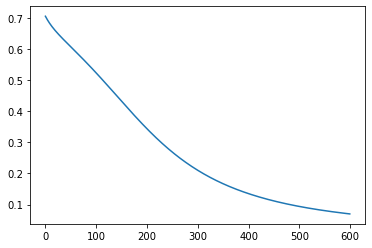

In [237]:
n_epochs = 600
all_losses = []
for epoch in range(n_epochs):
    Y_pred = model(X_train_tensor)
    
    loss = criterion(Y_pred, Y_train_tensor)
    all_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}, learning rate = {learning_rate:2f}')
plt.figure()
plt.plot(all_losses)
plt.show()

In [238]:
with torch.no_grad():
    Y_pred = model(X_test_tensor)
    Y_pred_cls = Y_pred.round()
    acc = Y_pred_cls.eq(Y_test_tensor).sum() / float(Y_test_tensor.shape[0])
    print(f'accuracy= {acc:.4f}')

accuracy= 0.7820
